## 0. 성능 요약

TCN이 경우 R에 대해 R-squared 0.43수준으로 LSTM보다는 우수하며 LGBM보다는 우수하지 못함

B(t) ~ RF(t-1) ~ RF(t-30), B(t-1) ~ B(t-30) -> R-squared -> LSTM(0.963), LGBM(0.973)

R(t) ~ RF(t-1) ~ RF(t-30), R(t-1) ~ R(t-30) -> R-squared -> LSTM(0.166), LGBM(0.589)

Q(t) ~ RF(t-1) ~ RF(t-30), Q(t-1) ~ Q(t-30) -> R-squared -> LGBM(0.599) ~ R을 LGBM으로 예측한 것과 유사한 수준

Q(t) ~ pred_R + pred_B -> R-squared : 0.641


## 1. digital filter : separate from each component (base and run-off)

In [ ]:
# 구글 드라이브 연결 (파일을 불러오기 위해 필요)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 딥러닝 모형 학습을 위한 기능 import
# -*- coding: utf-8 -*-
%tensorflow_version 1.x
import tensorflow as tf

import pandas as pd
import numpy as np

import datetime
import os
import glob

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.models import Model

from keras import layers
from keras.layers import *
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam, RMSprop

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats

from statsmodels.distributions.empirical_distribution import ECDF
!pip install h5py==2.10.0

%matplotlib inline
print(tf.__version__)

# 사용할 머신러닝 알고리즘 import

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR

from sklearn.metrics import r2_score


TensorFlow 1.x selected.


Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 16.3 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


1.15.2


In [ ]:
# 구글 드라이브 파일경로(분석자마다 다르게 설정해야함)
path = '/content/drive/MyDrive/data/ten-day-inflow-avg/'

# 파일 읽기, 소양강 유역의 강우 및 유입량 데이터
df_input = pd.read_csv(path + 'soyang.csv')
df_input

,OBSYMD,DAMCD,RF,IQTY
0,19740101,1012110,0.0000,10.000
1,19740102,1012110,0.0000,9.000
2,19740103,1012110,0.0000,4.800
3,19740104,1012110,0.0000,6.100
4,19740105,1012110,0.0000,5.800
...,...,...,...,...
15985,20171007,1012110,0.1613,6.583
15986,20171008,1012110,0.0000,26.463
15987,20171009,1012110,0.0000,6.836
15988,20171010,1012110,1.9319,19.367


In [ ]:
Q = df_input['IQTY'].to_numpy().flatten()
Q

array([10.   ,  9.   ,  4.8  , ...,  6.836, 19.367, 54.967])

In [ ]:
a=0.95    #%baseflow filter parameter%

R = np.zeros(len(Q))
B = np.zeros(len(Q))
dif = np.zeros(len(Q))

for k in range(0, len(Q)-1):
  # 다음단계의 R은 현재 R * a와 Q의 변화량의 1/2 * (1+a)를 의미함
  #R(k+1)=a.*R(k)+((1+a).*(Q(k+1)-Q(k)))/2;
  R[k+1] = a * R[k] + ((1+a)*(Q[k+1] - Q[k]))/2
  
  # R이 0보다 작다면, 0으로 처리
  # if R(k+1)<0;
  #   R(k+1)=0;
  if R[k+1] < 0:
    R[k+1] = 0
  
  # R이 Q보다 크면 Q로 처리
  # if R(k+1)>Q(k+1);
  #   R(k+1)=Q(k+1);
  if R[k+1] > Q[k+1]:
    R[k+1] = Q[k+1]

  # B는 Q - R
  #B(k+1)=Q(k+1)-R(k+1);
  B[k+1] = Q[k+1] - R[k+1]

  # dif == R
  #dif(k+1)=Q(k+1)-B(k+1);
  dif[k+1] = Q[k+1] - B[k+1]

df = pd.DataFrame({'Q': Q, 'B': B, 'R': R, 'dif': dif, 'RF' : df_input['RF'] })
df

,Q,B,R,dif,RF
0,10.000,0.000000,0.000000,0.000000,0.0000
1,9.000,9.000000,0.000000,0.000000,0.0000
2,4.800,4.800000,0.000000,0.000000,0.0000
3,6.100,4.832500,1.267500,1.267500,0.0000
4,5.800,4.888375,0.911625,0.911625,0.0000
...,...,...,...,...,...
15985,6.583,6.583000,0.000000,0.000000,0.1613
15986,26.463,7.080000,19.383000,19.383000,0.0000
15987,6.836,6.836000,0.000000,0.000000,0.0000
15988,19.367,7.149275,12.217725,12.217725,1.9319


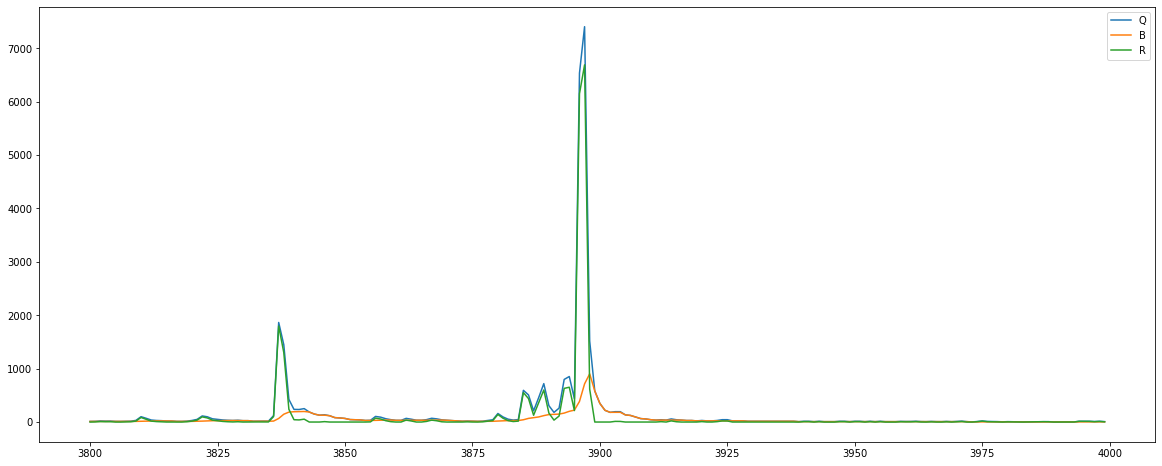

In [ ]:
df[['Q', 'B', 'R']][3800:4000].plot(figsize=(20,8))

## 2-1. Predict Baseflow using LSTM

In [ ]:
# 3차원 입력데이터를 만들기 위해 df_in이라는 데이터프레임으로 복사

df_in = df[['B', 'RF']].copy()

# 값들을 0~1로 Min-Max 정규화 처리함

# define scaler
# scaler = MinMaxScaler()
scaler = StandardScaler()

# fit scaler on the training dataset
scaler.fit(df_in.values)

# transform the training dataset
df_in_scaled = pd.DataFrame(scaler.transform(df_in.values), columns = df_in.columns)

# 30에 대해 2개의 변수를 가지는 2차원 데이터셋을 기본 형태로 하는 3차원데이터셋(2차원을 기본으로 하는 배열)을 생성
# y_shift는 이후 1일 후를 예측으로 함

x_range = 30
y_shift = 1
features = df_in_scaled.shape[1]
y_target_column = 'B'

nb_samples = df_in_scaled.shape[0] - (x_range + y_shift - 1)

dataset_X_reshaped = np.zeros((nb_samples, x_range, features))
dataset_y_reshaped = np.zeros((nb_samples, y_shift))

j = 0
for i in range(nb_samples):
  if ((np.isnan(df_in_scaled[i:(i+x_range)].to_numpy()).sum()) > 0) | (np.isnan(df_in[y_target_column][i+x_range+y_shift-1]).sum() > 0) :
    continue 
  dataset_X_reshaped[j] = df_in_scaled[i:(i+x_range)].to_numpy()
  dataset_y_reshaped[j] = df_in[y_target_column][i+x_range+y_shift-1].reshape(-1)
  j = j + 1

dataset_X_reshaped = dataset_X_reshaped[0:j]
dataset_y_reshaped = dataset_y_reshaped[0:j]

print(dataset_X_reshaped.shape)
#print(dataset_X_reshaped)

print(dataset_y_reshaped.shape)
#print(dataset_y_reshaped)

#X_train, X_test, y_train, y_test = train_test_split(dataset_X_reshaped, dataset_y_reshaped, test_size=0.01)

# 15000번째 까지를 훈련데이터셋으로
# 그이후를 테스트데이터셋으로 구성함
X_train = dataset_X_reshaped[0:10000,:,:]
X_val = dataset_X_reshaped[10000:15000,:,:]
X_test = dataset_X_reshaped[15000:,:,:]

y_train = dataset_y_reshaped[0:10000]
y_val = dataset_y_reshaped[10000:15000]
y_test = dataset_y_reshaped[15000:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15960, 30, 2)
(15960, 1)
(10000, 30, 2)
(960, 30, 2)
(10000, 1)
(960, 1)


In [ ]:
# 기본 lstm모형을 생성
# lstm 은 stacked lstm형태로, stacked될 경우 return_sequence = TRUE 옵션 필요
# training=True옵션을 통해 dropout을 이용하여 매번 다른 결과값이 생성됨
# early stopping을 적용하여, 최적의 epoch를 결정함
# 현재 patience는 5로 설정되어 있음

def base_lstm(X_train, y_train, verbose = 1):
  inputs = Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
  x1 = LSTM(32, return_sequences=True)(inputs) 
  x2 = LSTM(32, return_sequences=False)(x1) 
  output = Dense(units = 1, activation='linear', name='OUTPUT')(x2)
  model = Model(inputs=inputs, outputs=output)

  opt = Adam()

  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  
  epc = 1000
  es = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
  
  
  
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epc, verbose=verbose, callbacks=[es], 
                      batch_size=128)
  return model
 
model_base = base_lstm(X_train, y_train)

Train on 10000 samples, validate on 5000 samples
Epoch 1/1000
10000/10000 [==============================] - 5s 496us/step - loss: 3012.9108 - mae: 27.2778 - val_loss: 3584.3788 - val_mae: 26.4919
Epoch 2/1000
10000/10000 [==============================] - 5s 451us/step - loss: 2735.3139 - mae: 24.4408 - val_loss: 3454.2427 - val_mae: 25.7729
Epoch 3/1000
10000/10000 [==============================] - 5s 454us/step - loss: 2613.1726 - mae: 22.4477 - val_loss: 3326.0056 - val_mae: 23.3479
Epoch 4/1000
10000/10000 [==============================] - 7s 653us/step - loss: 2505.0192 - mae: 20.8510 - val_loss: 3217.2686 - val_mae: 22.0150
Epoch 5/1000
10000/10000 [==============================] - 6s 595us/step - loss: 2409.8390 - mae: 19.7663 - val_loss: 3118.2898 - val_mae: 20.9848
Epoch 6/1000
10000/10000 [==============================] - 4s 434us/step - loss: 2323.5451 - mae: 18.7956 - val_loss: 3027.9905 - val_mae: 20.0457
Epoch 7/1000
10000/10000 [==============================] - 4s 

In [ ]:
y_pred = model_base.predict(X_test)
y_obs = y_test

In [ ]:
df_pred = pd.DataFrame({'Date' : df_input['OBSYMD'][15030:].values, 'Obs' : y_obs.flatten(), 'Pred' : y_pred.flatten(), 'RF' : df_input['RF'][15030:].values})
df_pred['Date'] = df_pred['Date'].apply(lambda x: pd.to_datetime(str(int(x)), format='%Y%m%d')) 

df_pred

,Date,Obs,Pred,RF
0,2015-02-25,3.292009,3.034233,0.7594
1,2015-02-26,3.828308,3.546513,0.8506
2,2015-02-27,4.081893,4.167562,0.0000
3,2015-02-28,4.235648,4.353836,0.0000
4,2015-03-01,4.029000,4.415704,0.0000
...,...,...,...,...
955,2017-10-07,6.583000,6.418541,0.1613
956,2017-10-08,7.080000,6.399300,0.0000
957,2017-10-09,6.836000,6.932923,0.0000
958,2017-10-10,7.149275,6.523294,1.9319


In [ ]:
r2=r2_score(df_pred['Obs'].to_numpy(), df_pred['Pred'].to_numpy())
r2

0.9634170422779796

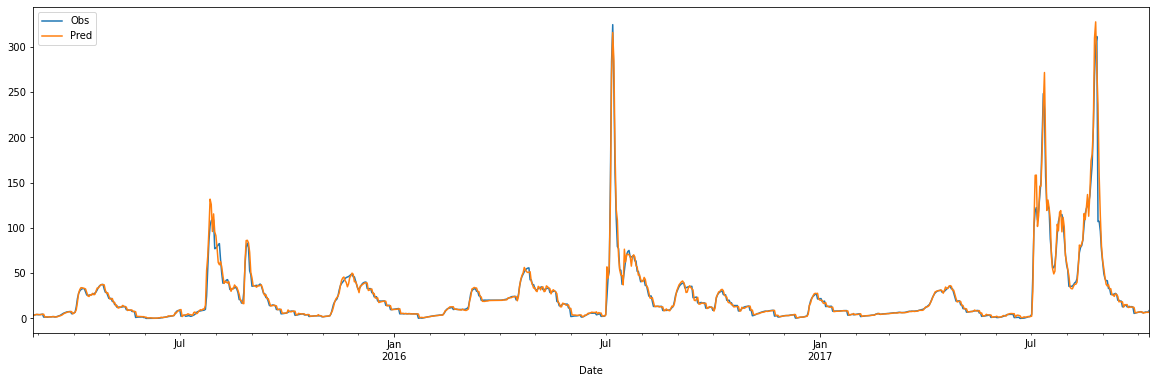

In [ ]:
df_pred[['Date', 'Obs', 'Pred']].set_index('Date').plot(figsize=(20,6))

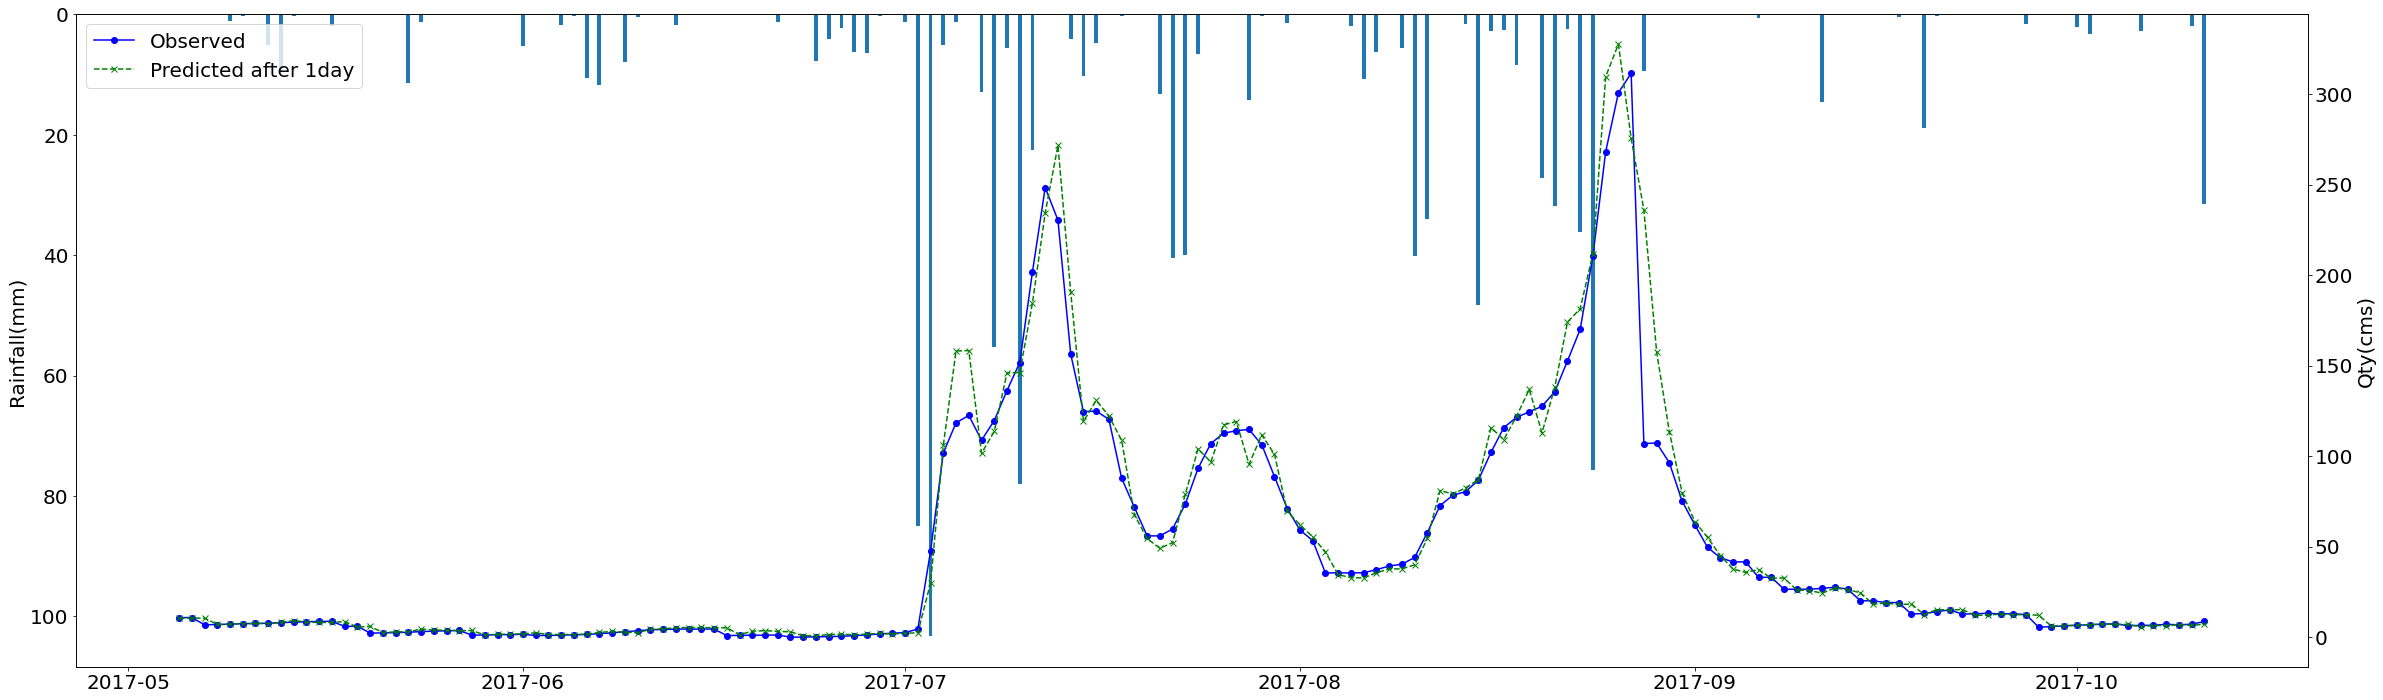

In [ ]:
df_predict = df_pred[800:1000].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1day'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

## 3-1. Predict surface flow using TCN

In [ ]:
# 3차원 입력데이터를 만들기 위해 df_in이라는 데이터프레임으로 복사

df_in = df[['R', 'RF']].copy()

# 값들을 0~1로 Min-Max 정규화 처리함

# define scaler
# scaler = MinMaxScaler()
scaler = StandardScaler()

# fit scaler on the training dataset
scaler.fit(df_in.values)
# transform the training dataset
df_in_scaled = pd.DataFrame(scaler.transform(df_in.values), columns = df_in.columns)

# 30에 대해 2개의 변수를 가지는 2차원 데이터셋을 기본 형태로 하는 3차원데이터셋(2차원을 기본으로 하는 배열)을 생성
# y_shift는 이후 1일 후를 예측으로 함

x_range = 30
y_shift = 1
features = df_in_scaled.shape[1]
y_target_column = 'R'

nb_samples = df_in_scaled.shape[0] - (x_range + y_shift - 1)

dataset_X_reshaped = np.zeros((nb_samples, x_range, features))
dataset_y_reshaped = np.zeros((nb_samples, y_shift))

j = 0
for i in range(nb_samples):
  if ((np.isnan(df_in_scaled[i:(i+x_range)].to_numpy()).sum()) > 0) | (np.isnan(df_in[y_target_column][i+x_range+y_shift-1]).sum() > 0) :
    continue 
  dataset_X_reshaped[j] = df_in_scaled[i:(i+x_range)].to_numpy()
  dataset_y_reshaped[j] = df_in[y_target_column][i+x_range+y_shift-1].reshape(-1)
  j = j + 1

dataset_X_reshaped = dataset_X_reshaped[0:j]
dataset_y_reshaped = dataset_y_reshaped[0:j]

print(dataset_X_reshaped.shape)
#print(dataset_X_reshaped)

print(dataset_y_reshaped.shape)
#print(dataset_y_reshaped)

#X_train, X_test, y_train, y_test = train_test_split(dataset_X_reshaped, dataset_y_reshaped, test_size=0.01)

# 15000번째 까지를 훈련데이터셋으로
# 그이후를 테스트데이터셋으로 구성함
X_train = dataset_X_reshaped[0:10000,:,:]
X_val = dataset_X_reshaped[10000:15000,:,:]
X_test = dataset_X_reshaped[15000:,:,:]

y_train = dataset_y_reshaped[0:10000]
y_val = dataset_y_reshaped[10000:15000]
y_test = dataset_y_reshaped[15000:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15960, 30, 2)
(15960, 1)
(10000, 30, 2)
(960, 30, 2)
(10000, 1)
(960, 1)


In [ ]:
# 기본 tcn모형을 생성
# TCN 참고 : https://stackoverflow.com/questions/52578950/causal-padding-in-keras
# Conv1D함수 참고 : https://keras.io/ko/layers/convolutional/

def base_tcn(X_train, y_train, verbose = 1):
  inputs = Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
  x = Conv1D(filters = 256, kernel_size = 10, padding = 'causal', activation = 'relu')(inputs) 
  x = Conv1D(filters = 256, kernel_size = 10, padding = 'causal', activation = 'relu')(x) 
  x = Flatten()(x)
  x = Dropout(0.05)(x)
  output = Dense(units = 1, activation='linear', name='OUTPUT')(x)
  model = Model(inputs=inputs, outputs=output)

  print(model.summary())
  opt = Adam()

  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  
  epc = 1000
  es = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
  
  
  
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epc, verbose=verbose, callbacks=[es], 
                      batch_size=128)
  return model
 
model_base = base_tcn(X_train, y_train)


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30, 2)             0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 30, 256)           5376      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 30, 256)           655616    
_________________________________________________________________
flatten_7 (Flatten)          (None, 7680)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7680)              0         
_________________________________________________________________
OUTPUT (Dense)               (None, 1)                 7681      
Total params: 668,673
Trainable params: 668,673
Non-trainable params: 0
_____________________________________________________

In [ ]:
y_pred = model_base.predict(X_test)
y_obs = y_test

df_pred = pd.DataFrame({'Date' : df_input['OBSYMD'][15030:].values, 'Obs' : y_obs.flatten(), 'Pred' : y_pred.flatten(), 'RF' : df_input['RF'][15030:].values})
df_pred['Date'] = df_pred['Date'].apply(lambda x: pd.to_datetime(str(int(x)), format='%Y%m%d')) 

df_pred

,Date,Obs,Pred,RF
0,2015-02-25,14.125991,1.322334,0.7594
1,2015-02-26,6.789692,1.131856,0.8506
2,2015-02-27,3.100107,1.473482,0.0000
3,2015-02-28,2.896352,1.705246,0.0000
4,2015-03-01,0.000000,1.887179,0.0000
...,...,...,...,...
955,2017-10-07,0.000000,7.233773,0.1613
956,2017-10-08,19.383000,6.796857,0.0000
957,2017-10-09,0.000000,3.781963,0.0000
958,2017-10-10,12.217725,3.487907,1.9319


In [ ]:
r2=r2_score(df_pred['Obs'].to_numpy(), df_pred['Pred'].to_numpy())
r2

0.43111382607724014

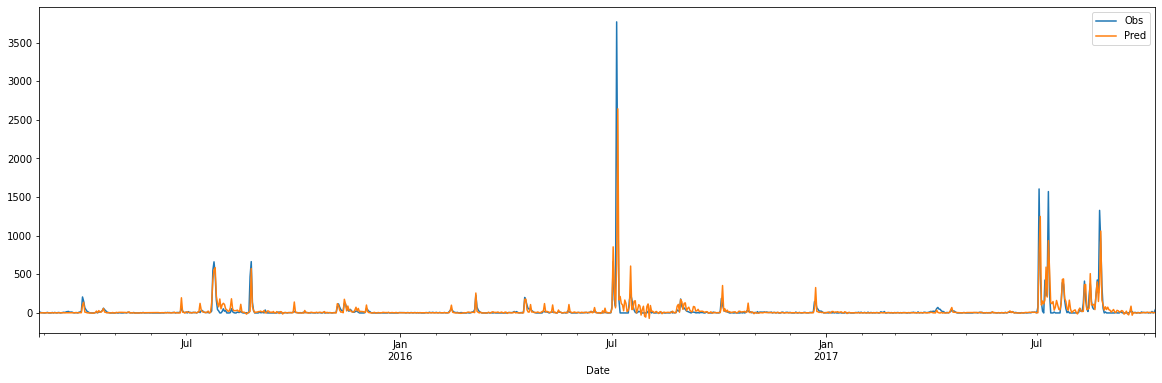

In [ ]:
df_pred[['Date', 'Obs', 'Pred']].set_index('Date').plot(figsize=(20,6))

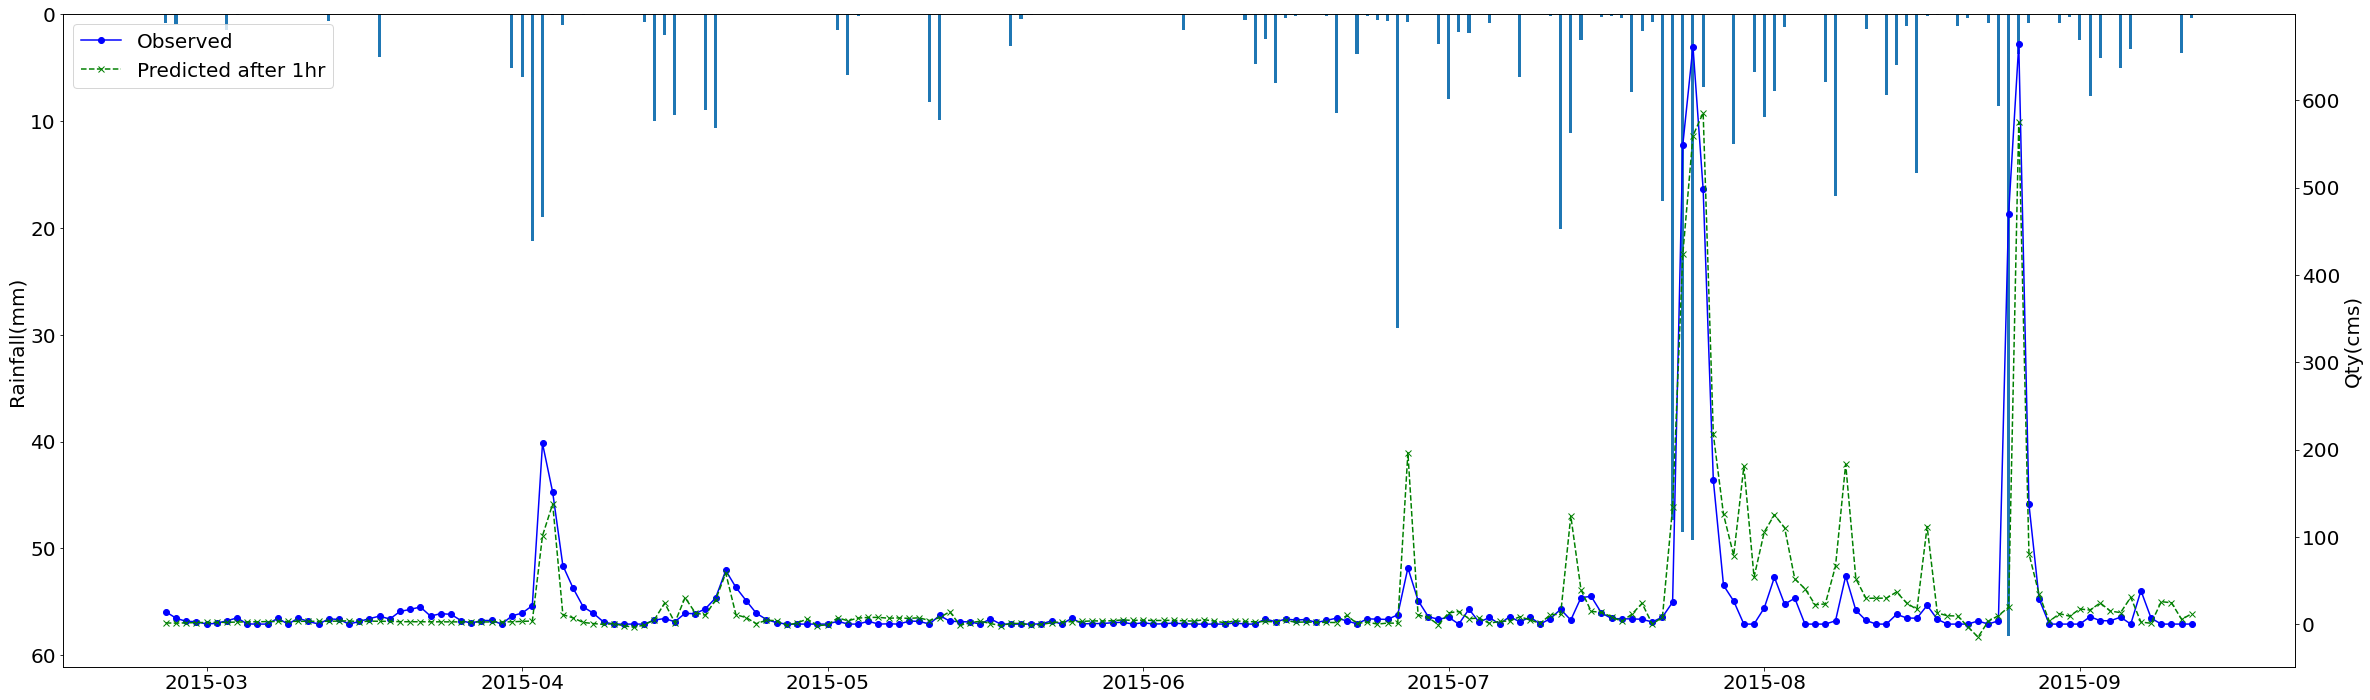

In [ ]:
df_predict = df_pred[0:200].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1hr'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

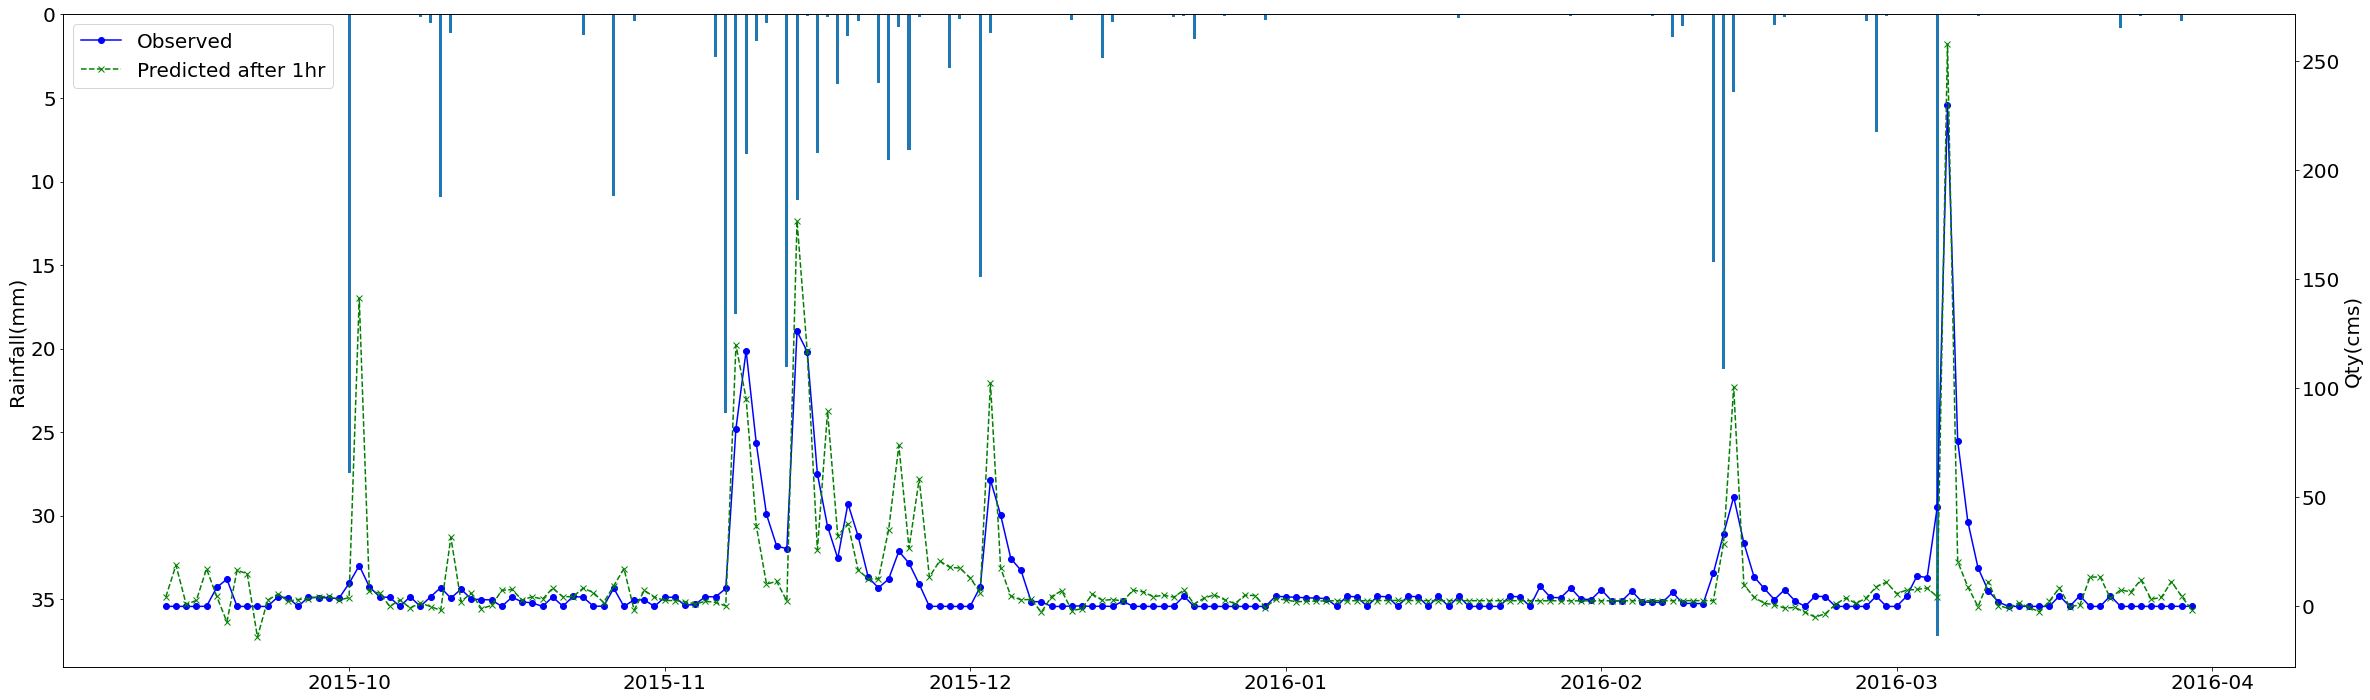

In [ ]:
df_predict = df_pred[200:400].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1hr'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

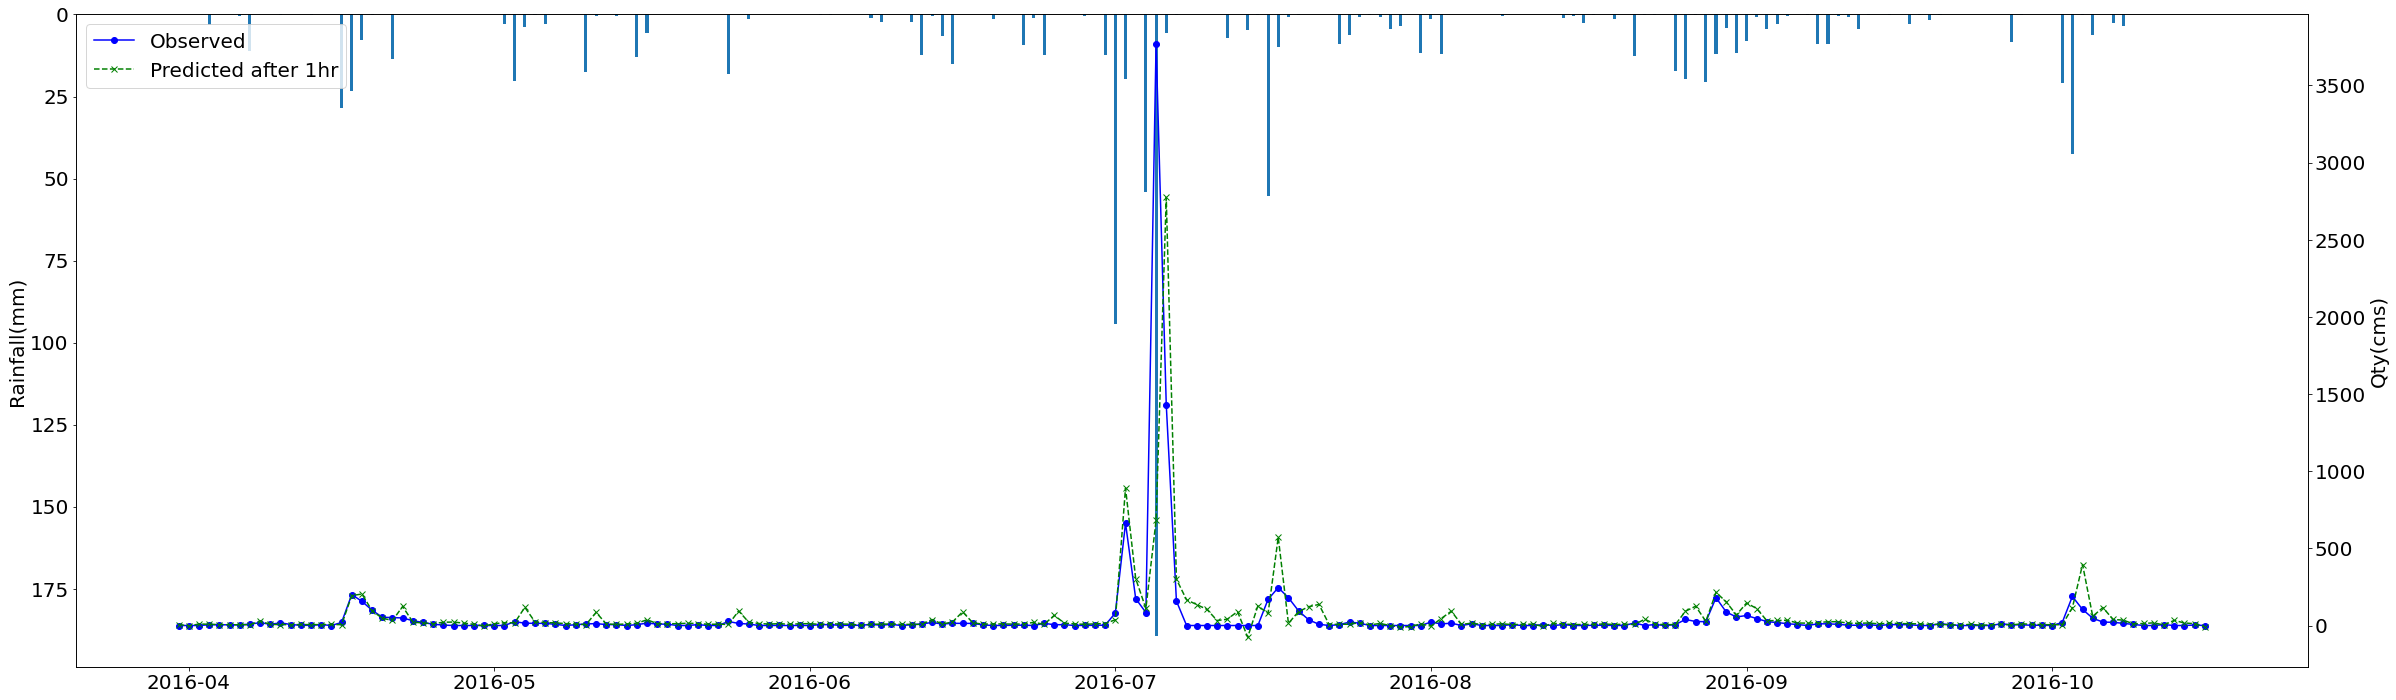

In [ ]:
df_predict = df_pred[400:600].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1hr'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

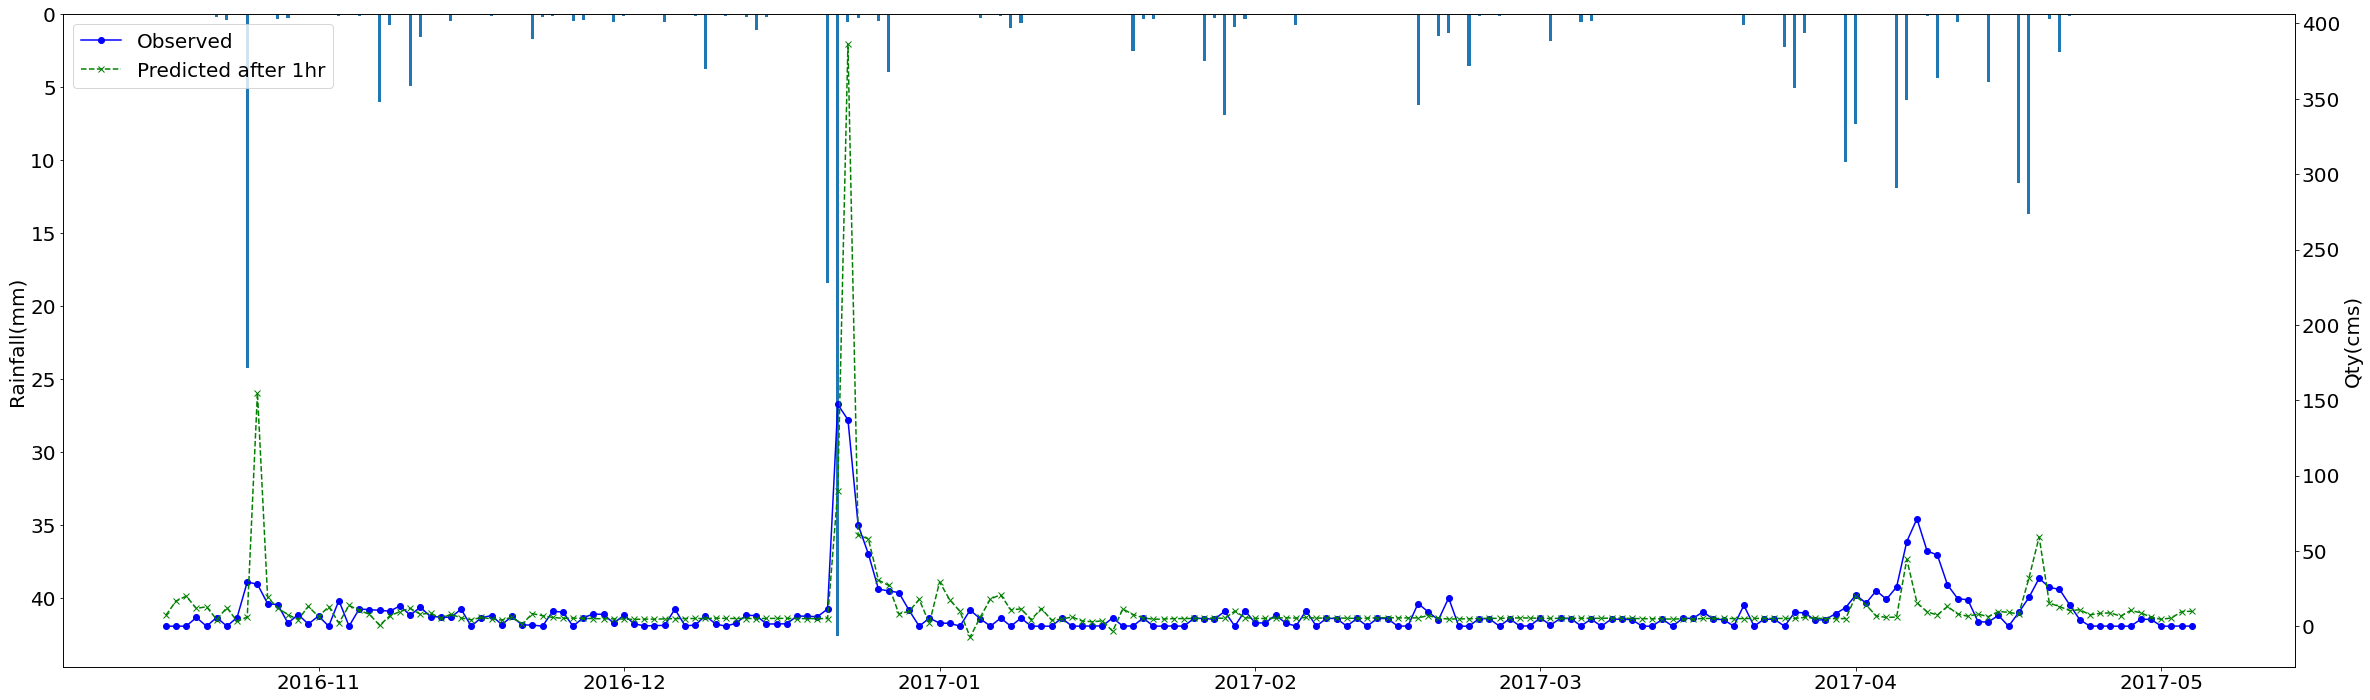

In [ ]:
df_predict = df_pred[600:800].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1hr'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)